In [1]:
from   category_encoders       import *
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from   sklearn.compose         import *
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from   sklearn.linear_model    import LogisticRegression
from   sklearn.metrics         import classification_report, accuracy_score, f1_score
from   sklearn.model_selection import train_test_split
from   sklearn.pipeline        import Pipeline
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from   sklearn.preprocessing   import *

## Research Question

Vegas releases betting odds in order to attract bettors to bet on the outcome of a certain sports event. However there is a fine line between attracting people to actually bet on the games so that external bettors will lose and the organization in Vegas makes the most money out of lost bets. In this project, I will be introducing several models and picking the best model that this certain organization in Vegas can use to figure out which team will likely win a sports match and so entice bettors who bet that the other team would win, and thus win all of their money. 

In this project, we will be using data from the National Basketball Association (NBA) to figure out which team will win a given basketball matchup

In [2]:
# Bringing in NBA data since 2018
nba_data = pd.read_csv('nba_data.csv', )
nba_data = nba_data.drop(nba_data.columns[0], axis=1)
nba_data.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,Year,HOME_TEAM,VISITOR_TEAM
0,2020-12-19,12000047,Final,1610612753,1610612766,2020,1610612753,120.0,0.433,0.792,...,117.0,0.444,0.864,0.439,21.0,52.0,1,2020,Magic,Hornets
1,2020-12-17,12000032,Final,1610612753,1610612766,2020,1610612753,115.0,0.474,0.917,...,123.0,0.475,0.900,0.439,32.0,43.0,0,2020,Magic,Hornets
2,2019-02-14,21800864,Final,1610612753,1610612766,2018,1610612753,127.0,0.522,0.778,...,89.0,0.351,0.731,0.129,18.0,45.0,1,2019,Magic,Hornets
3,2020-01-30,21900715,Final,1610612764,1610612766,2019,1610612764,121.0,0.477,0.926,...,107.0,0.434,0.632,0.300,32.0,38.0,1,2020,Wizards,Hornets
4,2019-11-22,21900216,Final,1610612764,1610612766,2019,1610612764,125.0,0.527,0.750,...,118.0,0.516,1.000,0.412,24.0,44.0,1,2019,Wizards,Hornets


## PCA Visualization

This section is important for the presentation of the model to show what the model thinks are the best teams in the league since 2018 based on the given stats described below. These are all based on offensive team stats. 

No interpretability on what the PCA values represent (flaw in PCA approach) but just use the graphical approach to show the best teams (according to who is at the most upper right on each of the plots). 

### First find the Best Teams when They Play in Their Home Court

In [3]:
# Have five features for each team
result_home = nba_data[['HOME_TEAM', 'FG_PCT_home', 'FT_PCT_home', "FG3_PCT_home", 
                     "AST_home", "REB_home"]]
result_home = result_home.groupby(["HOME_TEAM"]).mean()

In [4]:
# reduce the dimension of the number of features from 5 to 2
pipe = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=2))]) # to graph on 2d axis
pipe.fit(result_home)
res = pipe.transform(result_home)
result_home['pca_1'] = res[:, 0]
result_home['pca_2'] = res[:, 1]

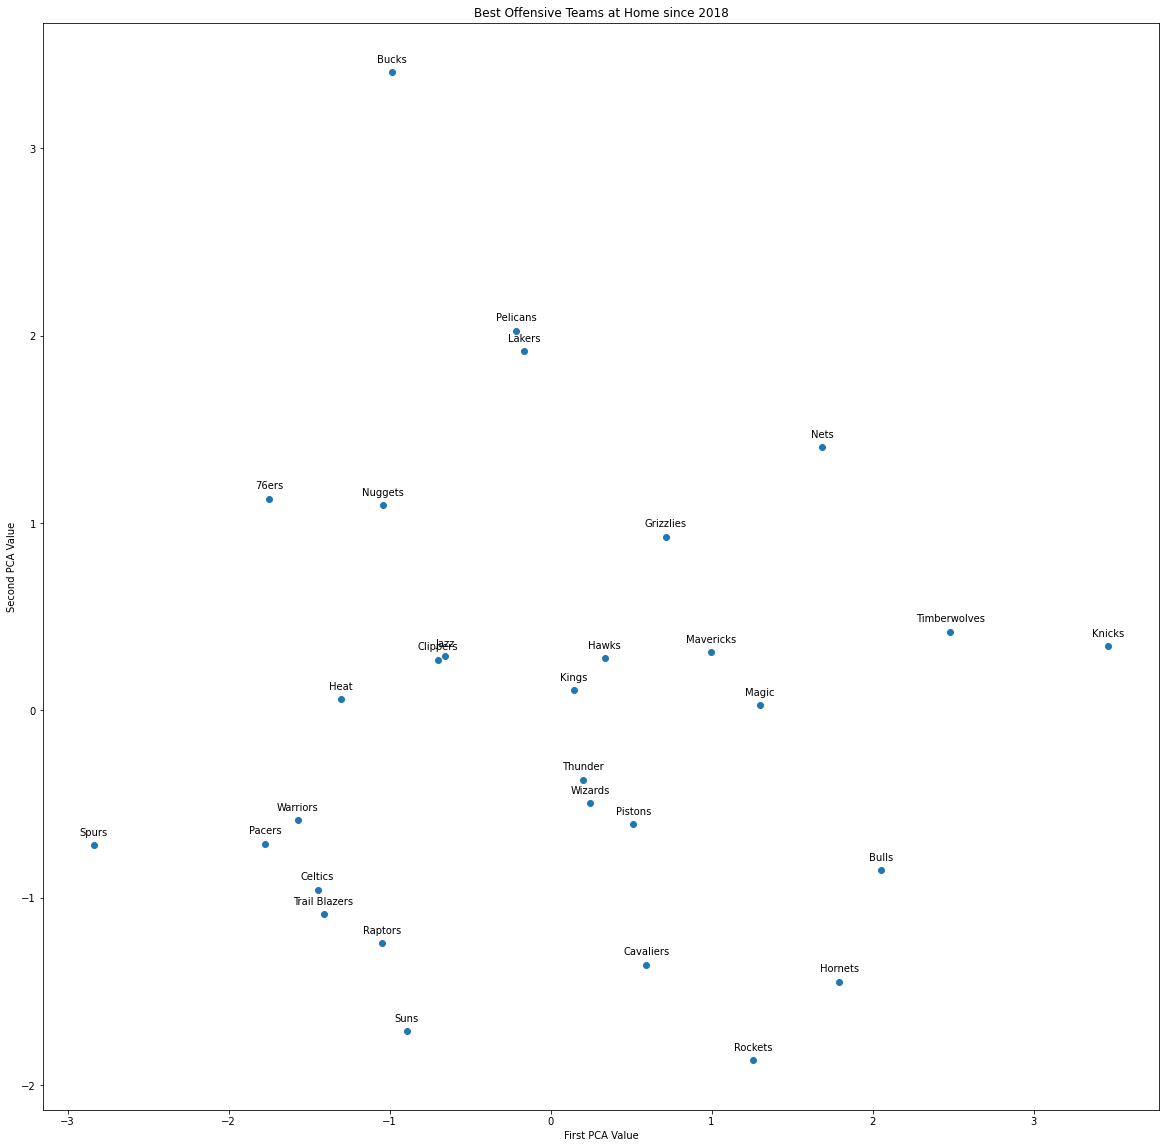

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("Best Offensive Teams at Home since 2018")
ax.set_ylabel("Second PCA Value")
ax.set_xlabel("First PCA Value")
ax.scatter(result_home['pca_1'], result_home['pca_2'])
for team in result_home.index:

    label = team
    x = result_home.loc[team]['pca_1']
    y = result_home.loc[team]['pca_2']

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 

### First find the Best Teams when They Play in an Opposing Team's Court

In [6]:
result_visitor = nba_data[['VISITOR_TEAM', "FG_PCT_away", "FT_PCT_away", "FG3_PCT_away", 
                      'AST_away','REB_away']]
result_visitor = result_visitor.groupby(["VISITOR_TEAM"]).mean()

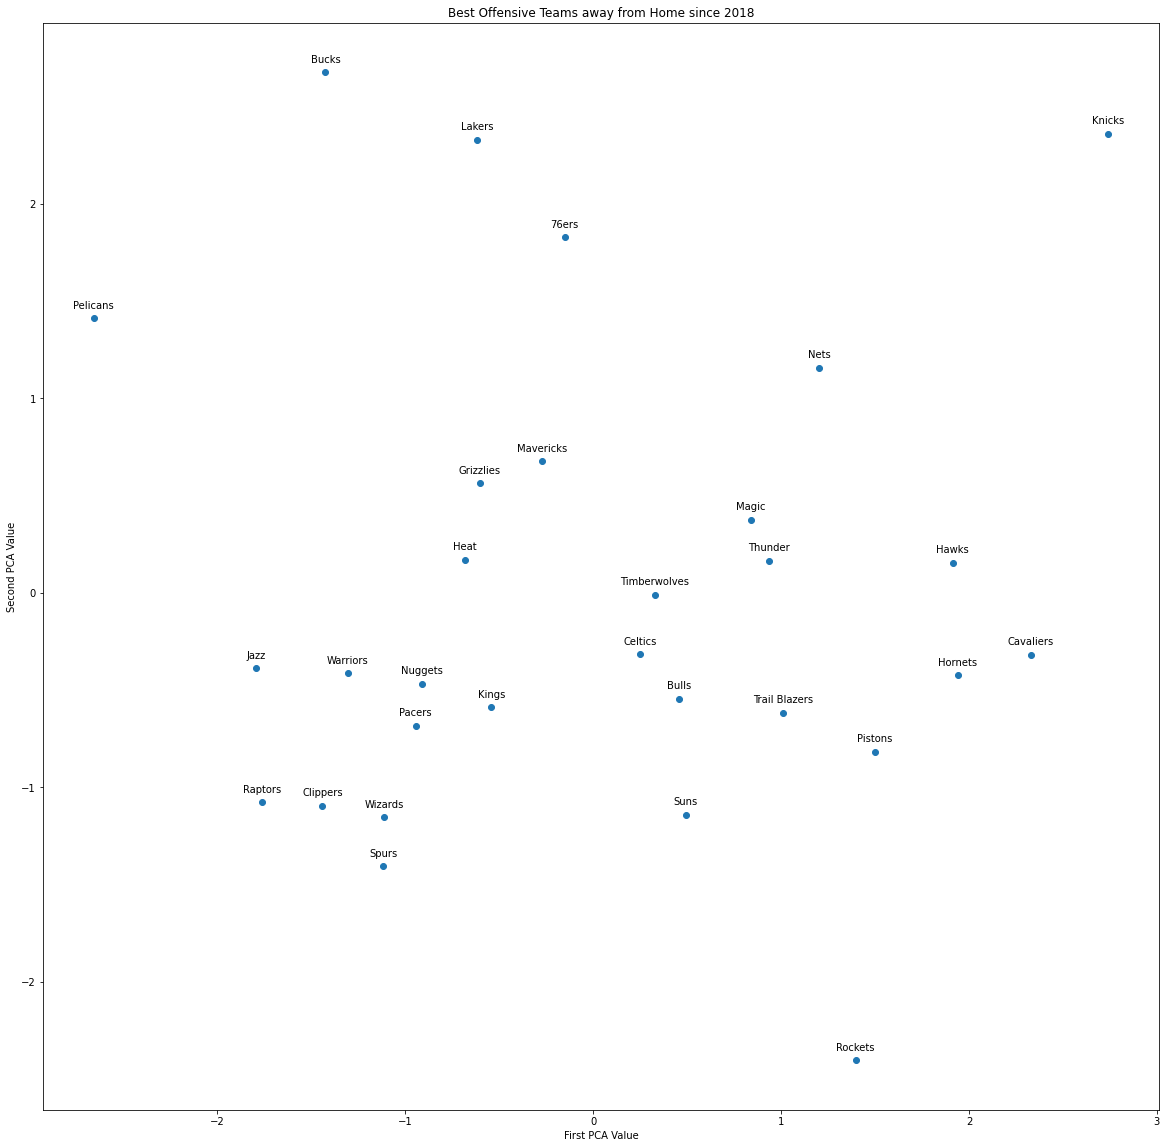

In [7]:
pipe = Pipeline([('scaler', StandardScaler()), 
                    ('pca', PCA(n_components=2))])
pipe.fit(result_visitor)
res = pipe.transform(result_visitor)
result_visitor['pca_1'] = res[:, 0]
result_visitor['pca_2'] = res[:, 1]

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("Best Offensive Teams away from Home since 2018")
ax.set_ylabel("Second PCA Value")
ax.set_xlabel("First PCA Value")
ax.scatter(result_visitor['pca_1'], result_visitor['pca_2'])
for team in result_visitor.index:

    label = team
    x = result_visitor.loc[team]['pca_1']
    y = result_visitor.loc[team]['pca_2']

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 

## Fit Sci-kit Learn Models

The analytic goal here is to perform classification. In the context of this problem we will be predicting which team will win in a given game given the stats they had for that particular game. When we do inference we will be using the average of the previous games to predict the next game as I will show towards the end of the document. But for now, we will look at in game stats to predict the outcome of games. 

I will be using a sci-kit learn pipeline to predict whether a home team or away team wins

In [16]:
X = nba_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'FG_PCT_home', 'FT_PCT_home', "FG3_PCT_home", 
                     "AST_home", "REB_home", "FG_PCT_away", "FT_PCT_away", "FG3_PCT_away", 
                      'AST_away','REB_away']]
y = nba_data[['HOME_TEAM_WINS']].values
y = y.reshape((len(y), ))

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

For this model, the features are each home and away team as well as stats for each team during that particular game they played. The features are described below: 

- HOME_TEAM_ID --> numerical representation of the home team (team playing in their home stadium)
- VISITOR_TEAM_ID --> numerical representation of the away team (team playing in their away stadium)
- SEASON --> the season (2018, 2019, 2020) that the game is being played in
- FG_PCT_home --> the home team's field goal percentage (percentage of shots taken that went in the basket)
- FT_PCT_home --> the home team's free throw percentage (percentage of free throws taken that went in the basket)
- FG3_PCT_home --> the home team's 3 point percentage (percentage of shots beyond the three point line taken that went in the basket)
- AST_home --> the amount of assists the home team recorded
- REB_home --> the amount of rebounds the home team recorded
- FG_PCT_away --> the away team's field goal percentage (percentage of shots taken that went in the basket)
- FT_PCT_away --> the away team's free throw percentage (percentage of free throws taken that went in the basket)
- FG3_PCT_away --> the away team's 3 point percentage (percentage of shots beyond the three point line taken that went in the basket)
- AST_away --> the amount of assists the away team recorded
- REB_away --> the amount of rebounds the away team recorded

### Logistic Regression

For the logistic regression model, make sure to standardize the data so that one column is not weighed too much more than the other. Also set them to the same distribution so that the model can easily compare two values from different columns

Deal with missing data by using a simple imputer to impute the median of other column values as so to not affect the total distribution. 

In [19]:
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('imputer', SimpleImputer(strategy='median', add_indicator=True)), 
                 ('preprocessing', QuantileTransformer(output_distribution='uniform')), # same distn
                 ('logreg', LogisticRegression())])

In [26]:
# Find best parameters for Logistic Regression
penalty = ['l1', 'l2', 'elasticnet', 'none']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C = np.logspace(0, 4, 10)
class_weight = [None, 'balanced']

rsc = RandomizedSearchCV(estimator=pipe, 
                        param_distributions={'logreg__penalty': penalty, 
                                             'logreg__solver': solver, 
                                             'logreg__C': C, 
                                             'logreg__class_weight': class_weight}, 
                        scoring='balanced_accuracy', # use as quick baseline to compare
                        n_iter=15, cv=5, n_jobs=-1, verbose=False)

result=rsc.fit(X, y)
# print("Best HyperParameters for Logistic Regression: ")
# print(result.best_params_)

Best Hyperparameters for Logistic Regression: 

- solver = 'liblinear'
- penalty = 'l2'
- class_weight = 'balanced'
- C = 2.78

This is randomized so the best hyperparameters will change at every run. 
However, randomized search is very efficient. 

In [27]:

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('imputer', SimpleImputer(strategy='median', add_indicator=True)), 
                 ('preprocessing', QuantileTransformer(output_distribution='uniform')),  # same distn
                 ('logreg', LogisticRegression(solver='liblinear', penalty='l2', 
                                               class_weight='balanced', 
                                               C = 2.78))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_valid)

### Random Forests

Do not need a standard scaler for random forests the nature of the algorithm doesn't have issues with unscaled data. 

In [29]:
pipe_rf = Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)), 
                    ('preprocessing', QuantileTransformer(output_distribution='uniform')),
                    ('rf', RandomForestClassifier())])

# Do Hyperparameter Tuning using RandomizedSearchCV
#Find best parameters for Random Forests
n_estimators = np.arange(10)
criterion = ['gini', 'entropy']
max_depth = [None, 5, 10, 15, 20, 25, 30]
min_samples_split = np.arange(2, 40)
min_samples_leaf = np.arange(1, 30)
max_features = ['auto', 'sqrt', 'log2']
max_samples = [None, 0.25, 0.33, 0.5, 0.67, 0.8]
class_weight = ['balanced', 'balanced_subsample']

rsc_rf = RandomizedSearchCV(estimator=pipe_rf, 
                        param_distributions={'rf__n_estimators': n_estimators, 
                                             'rf__criterion': criterion,
                                             'rf__max_depth': max_depth,
                                             'rf__min_samples_split': min_samples_split, 
                                             'rf__min_samples_leaf': min_samples_leaf, 
                                             'rf__max_features': max_features, 
                                             'rf__max_samples': max_samples, 
                                             'rf__class_weight': class_weight},
                        scoring='balanced_accuracy', 
                        n_iter=15, cv=5, n_jobs=-1, verbose=False)


result=rsc_rf.fit(X_train, y_train)
#print(result.best_params_)

Best Hyperparameters: 

- n_estimators = 6
- min_samples_split = 8
- min_samples_leaf = 11
- max_samples = None
- max_features = 'sqrt'
- max_depth = None
- criterion = gini
- class_weight = balanced

In [30]:
pipe_rf = Pipeline([('imputer', SimpleImputer(strategy='median', add_indicator=True)), 
                    ('preprocessing', QuantileTransformer(output_distribution='uniform')), 
                    ('rf', RandomForestClassifier(n_estimators=5, min_samples_split=8,
                                                  max_depth=None, criterion='gini', 
                                                  max_features='sqrt',
                                                  min_samples_leaf=24, 
                                                  max_samples = None, 
                                                  class_weight = 'balanced'))])
pipe_rf.fit(X_train, y_train)
y_pred_rf = pipe_rf.predict(X_valid)

## Evaluation Metric

### Interpret Precision and Recall

Precision for 0 --> Out of all the times the model predicted that the visiting team would win, the chance that the visiting team actually won

Precision for 1 --> Out of all the times the model predicted that the home team would win, the chance that the home team actually won

Recall for 0 --> Out of all the times that the visiting team actually won, the chance that the model predicted that the visiting team won

Recall for 1 --> Out of all the times that the home team actually won, the chance that the model predicted that the home team won

### Logistic Regression Results

In [31]:
accuracy_score(y_pred, y_valid)

0.8385214007782101

In [32]:
print("Logistic Regression")
print(classification_report(y_pred, y_valid))

Logistic Regression
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       253
           1       0.82      0.88      0.85       261

    accuracy                           0.84       514
   macro avg       0.84      0.84      0.84       514
weighted avg       0.84      0.84      0.84       514



Using Logistic regression, the precisions and the recalls were very different for the home team winning (target of 1) versus when the away team wins (target of 0). Therefore as a bettor in Vegas, I would be much more comfortable if the model predicted that the away team wins since it predicts correctly that the away team wins 87% of the time while only 82% for the home team. 

However, out of all the home teams that actually won, the chance that the model predicted the home team would win was better than that of the away team. In this sense, the model is good at picking up the correct predictions out of a set of predictions. 

### Random Forests Results

In [33]:
accuracy_score(y_pred_rf, y_valid)

0.7957198443579766

In [34]:
print("Random Forest Classification")
print(classification_report(y_pred_rf, y_valid))

Random Forest Classification
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       255
           1       0.77      0.84      0.81       259

    accuracy                           0.80       514
   macro avg       0.80      0.80      0.80       514
weighted avg       0.80      0.80      0.80       514



Using Random Forests Classification, the precisions were similar for the home team winning (target of 1) versus when the away team wins (target of 0) but the recalls were a bit more different. As a bettor, I would be a bit more comfortable when the model predicts an away team winning as opposed to the home team according to the precisions.

However, recall is a bit more varied, where the model has a better chance of "plucking" out predictions that the home team would win out of all the actual times the home team won as opposed to the away team. 

### Analysis of Metrics of the Two Models

Accuracy score was used as the first metric to compare the Logistic Regression and Random Forests results. Based on just accuracy, the logistic regression model performed the best. However, accuracy is flawed since it won't go into detail about how well the model is predicting a home team winning as opposed to an away team (precision of each) or the fact that out of all the home teams that lost, how many did the model predict and vice versa (recall of each). As an interpreter of the model, I want to know where the model performed well and where it performed poorly in more detail, which is why next, I will look at precision and recall between the two models

When looking at precision and recall, we can see that logistic regression overall performs better. However, we need to understand exactly in one what way it is performing better. It performs better in every way in precision and recall (for the predictions of the away team winning and the home team winning). In our case however, the customers of the model will be the business of the Vegas organization creating bets, and so it is best to use precision since this business wants to focus on how well the model predicts each future outcome based on a model result. This is why logistic regression will be used since the precision of the away team winning is 87% as opposed to 82% in the random forest classifier and for the home team winning, its 82% as opposed to 77%. 

### Pick the Logistic Regression Model

If the model predicts that the away team will win, Vegas would be 87% confident that its correct, or if the model predicts that the home team would win, Vegas should be about 82% confident that it is correct. In this sense, this Vegas betting organization should come up with betting odds accordingly for who would win the game so that they can maximize their profit based on the confidence given by the model. 

***It will be up to Vegas to figure out the best odds based on the model results. There is a fine line between Vegas trying to get as much money as possible for each bet while also enticing people to take the bets***

## Inference

In [37]:
pipe.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('imputer',
                 SimpleImputer(add_indicator=True, strategy='median')),
                ('preprocessing', QuantileTransformer()),
                ('logreg',
                 LogisticRegression(C=2.78, class_weight='balanced',
                                    solver='liblinear'))])

In [38]:
# Bring in the dataframe of average stats for the home team and away team
def inference(home_team_df, away_team_df, teams): 
    dataframe = {
        'HOME_TEAM_ID': [teams[0]], 
        'VISITOR_TEAM_ID': [teams[1]], 
        'SEASON': [2020], 
        'FG_PCT_home': [home_team_df['FG_PCT_home']], 
        'FT_PCT_home': [home_team_df['FT_PCT_home']], 
        "FG3_PCT_home": [home_team_df['FG3_PCT_home']], 
        "AST_home": [home_team_df['AST_home']], 
        "REB_home": [home_team_df['REB_home']], 
        "FG_PCT_away": [away_team_df['FG_PCT_away']], 
        "FT_PCT_away": [away_team_df['FT_PCT_away']], 
        "FG3_PCT_away": [away_team_df['FG3_PCT_away']],
        'AST_away': [away_team_df['AST_away']],
        'REB_away': [away_team_df['REB_away']]
    }
    return pd.DataFrame(dataframe)
home_team = 'Lakers'
away_team = 'Clippers'

# get team IDS for the home and away team
teams = [nba_data.set_index("HOME_TEAM").loc[home_team].iloc[0]['HOME_TEAM_ID'], 
         nba_data.set_index("VISITOR_TEAM").loc[away_team].iloc[0]['VISITOR_TEAM_ID']]
inference_df = inference(result_home.loc[home_team], result_visitor.loc[away_team], teams)

In [39]:
prediction = pipe.predict(inference_df)
prediction

array([0])

Therefore, with our model, the clippers would be predicted to win the away game against the lakers for that season. We can do this for any home and away team to predict who would win a corresponding game in the 2020 season in the logistic regression model. 

Overall Vegas should be about 87% confident about these results and create their betting odds accordingly. 

## Next Steps

1) Create different models for each respective team so each team gets a confidence index (from precision) so that Vegas can create odds based on how confident a model is for each respective team. 

2) Have the labels be point differential instead of just wins and losses (so make it a regression problem), but requires more detailed data extraction to find point differentials of previous games

3) Have a model that incorporates multiple sports (different ways for Vegas to make money)